### Are there characteristic three step transaction motifs that distinguish fraudulent behavior from legitimate activity in crypto transaction graphs? 

# Introduction and Dataset Selection

Cryptocurrency transaction networks provide rich temporal graph data that can reveal patterns of normal versus illicit behaviour. Motifs, defined as small recurring transaction patterns, have emerged as a powerful analytical tool for characterising transactions in these networks. Structural motifs (e.g. fan-in/fan-out structures, triangles or loops in fund flows) and temporal motifs (e.g. rapid series of transfers) can both be potentially utilised to characterise money laundering or scam behavior. We expect, for example, that illicit transactions may participate in more complex multi-step transfer patterns (due to obfuscation attempts) compared to ordinary transactions. In this project, we explore whether we can uncover distinctive three step transaction motifs that can help detect fraudulent activity (such as scams or money laundering) in cryptocurrency networks. For example, Arnold et al. (2024) use sequences of three transactions (temporal motifs) to analyze Bitcoin and Ethereum, finding that simple global motif counts can be misleading and that motif patterns per user are heavy-tailed, with a few “key players” exhibiting diverse motif signatures. They also show that examining motifs over time can uncover anomalous events not visible in aggregate counts. Additionally, temporal motifs have been used to identify illicit patterns for use cases such as detecting Bitcoin mixing services and Ethereum phishing scams. Building on these ideas, I aim to bridge graph motifs and fraud detection by analysing the three node motif structure in temporal network transaction data. The dataset I have chosen is Elliptic ++ introduced by Weber et al. (2019), as it contains a transaction graph, which can be better used to classify individual transactions since it preserves the precise flow of funds and temporal structure between transactions—unlike a wallet graph, which aggregates activity and introduces transaction ambiguity. In the Elliptic++ dataset, the transaction graph is a directed graph where nodes represent individual Bitcoin transactions and edges indicate the flow of Bitcoin from one transaction to another, signifying that the output of one transaction serves as the input to another. This structure captures the propagation of funds through the Bitcoin network, enabling the analysis of transaction patterns and the identification of potentially illicit activities. The Elliptic data provides 166 features per transaction (e.g. amounts, timestamps, in/out degrees), but for our motif analysis we primarily use the transaction graph structure and labels. This analysis could subsequently be extended to other cryptocurrency or transaction network data for future research. 

### Exploratory Analysis and Visualisation 

In the following, I carry out a basic EDA and attempt to describe abnd characterise the dataset and significant features of the network. This will inform the direction taken for motif analysis, and allow for an informed analysis going forwards. The notebook below performs this exploratory analysis and visualisation of transaction data in a directed graph structure as follows: 
- Loads transaction class labels (`licit`, `illicit`, and `unlabeled`) and counts transactions per class
- It constructs a directed graph of transactions where edges indicate value flow from one transaction to another. 
- Calculates the in-degree (number of in coming transactions) and out-degree (number of outgoing transactions) for each transaction and summarises these statistics by class.
- Visualises the in-degree and out-degree distributions of the dataset using log-scaled histograms.
- Visualises the in-degree and out-degree distributions of the classes 2 and 1 (illicit and licit labelled transactions respectively)
- Builds additional graphs linking transactions-wallets and wallets-wallets , which are potentially useful for deeper fraud and behaviour analysis at a later stage.
- A subgraph is created for a selected time step (I have chosen 10 at random), and transaction classes are visualised using colours to understand the structure at that snapshot in time.

Transaction class distribution:
class
3    157205
2     42019
1      4545
Name: count, dtype: int64


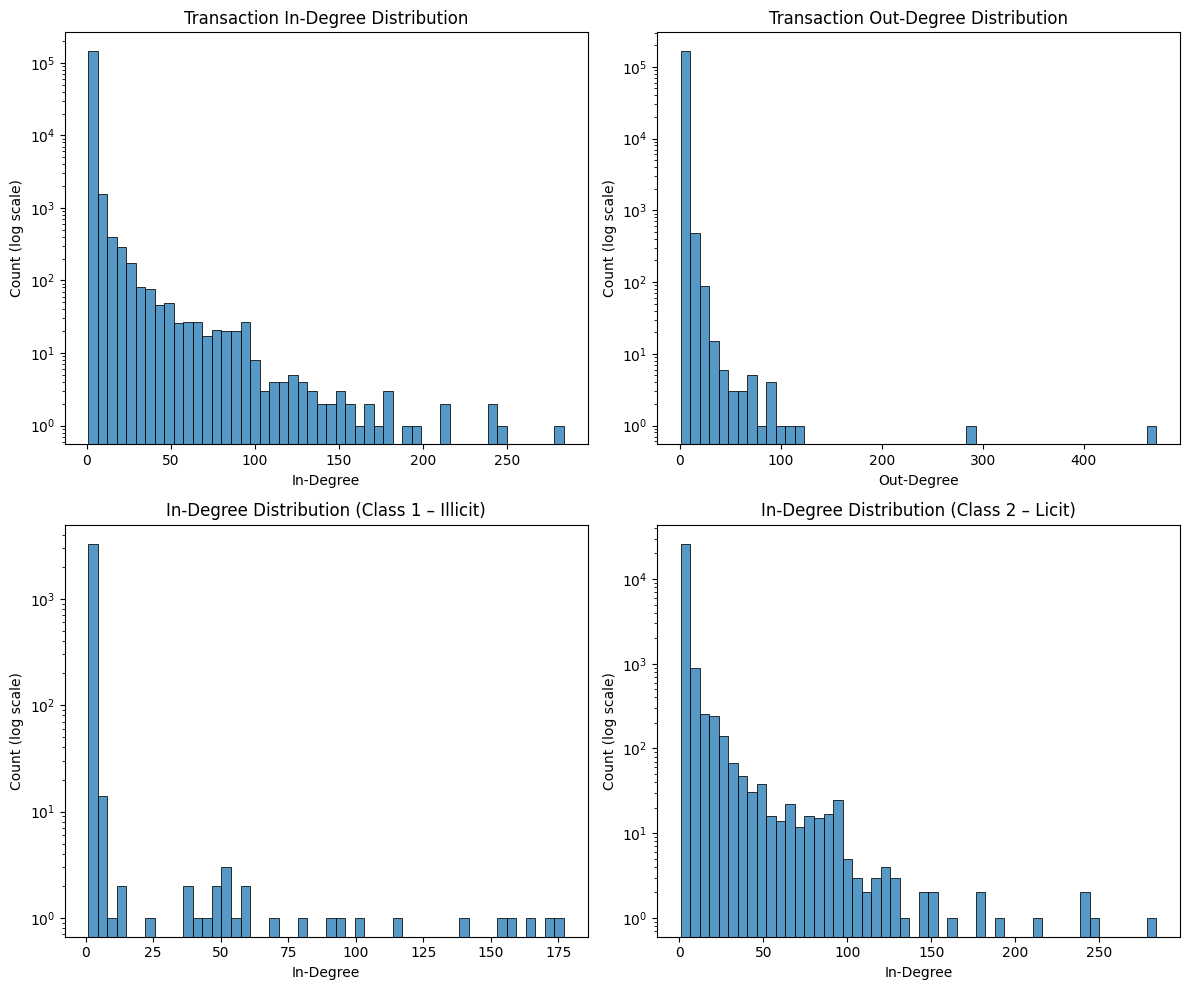

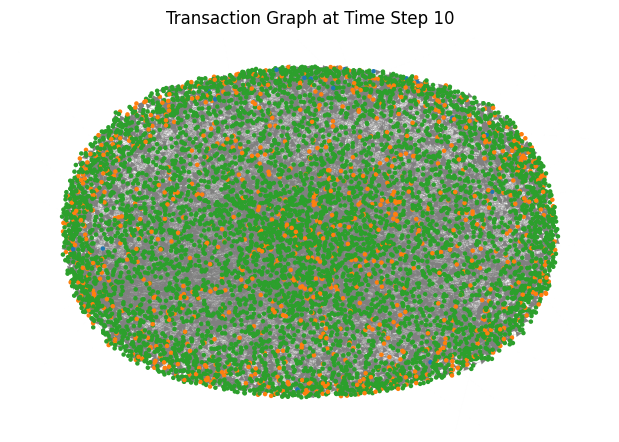

<Figure size 640x480 with 0 Axes>

In [12]:
%run EDA.py

This dataset consists of 203,769 Bitcoin transactions (nodes) and 234,000 payment edges connecting them, and transactions are organized in 49 temporal steps (each step aggregating transactions from a time window). Where available, transactions are labeled as licit (legitimate) or illicit (fraud-related), with the remainder unlabeled (unknown). This labelled subset of the data allows us to search for motif patterns specifically associated with illicit transactions, and leverage the labels to validate whether certain motifs correlate with fraudulent transactions. Approximately 2% (4,545) of the transactions are labelled as illicit and 21% (42,019) are licit, with 77% unknown. This severe class imbalance, which is highlighted clearly in the graph visualisation where we see hardly any blue dots, (illicit transactions are only 2% of all nodes) is typical in financial fraud data and we must be mindful of this when drawing conclusions at a later stage. 


There are several different graphs you could construct from this data, but I will primarily focus this analysis on the transaction graph. In this graph each node is a transaction, and an edge from A→B means transaction A’s output feeds into transaction B. Because of how Bitcoin’s UTXO model works, this graph is a directed acyclic graph (no cycles in fund flows). Even so, complex subgraph motifs can occur – e.g. one transaction splitting value to multiple outputs, or multiple inputs merging into one transaction. The above exploration of basic transaction connectivity patterns: for each transaction, computing its in-degree (number of predecessor transactions) and out-degree (number of successor transactions) gives us some preliminary insight into the differences between licit and illicit wallets. We can see from this that illicit transactions show slightly higher in/out degree on average, and a larger fraction of illicit transaction involve multiple inputs or outputs compared to licit ones. For example, about 8.7% of illicit transactions have more than one input (suggesting funds from multiple sources merged), versus ~5% for licit. Similarly, ~15% of illicit transactions split into multiple outputs, higher than the ~12% for licit. This aligns with intuition that fraud actors often mix funds from many sources or fan out funds to evade tracing. Further robust statistical analyis can be conducted to test this claim. 

The plot of input degree distribution for licit vs illicit transactions shows that the vast majority of transactions have 1 input (typical for Bitcoin), but there is a very long tail, with some transactions having hundreds of inputs and outputs. It appears this tail may be heavier for illicit transactions but more analysis will be needed to determine if this is the case. 

We can also see that for the labelled dataset, there are a singificant amount of transactions with multiple inputs for both illicit and licit, and it is these transactions that I will use to extract transaction-level motifs. 

### Defining and searching for motifs

In this section I build a scalable pipeline utilising Spark and GraphFrames  to detect and compare three-edge transaction motifs in the Elliptic++ data. I defined and searched for 36 canonical patterns (as defined in Arnold et. al (2024) )within the dataset, initially just allowing a single timestep (set as a parameter delta = 1) as the largest gap between the earliest and latest edge. I have limited my search to the 36 three edge motifs since these 36 motifs contain all the distinct weakly-connected, three-edge directed subgraphs you can form on up to three nodes. This allows my analysis to cover every possible small pattern of transaction flow (including chains, forks, reciprocations, and triangles) that can occur within a tight time window. This analysis could easily be extended to 4 node motifs and beyond to look for more complex patterns. 

The script below first loads the edge list and the time dimension of the directed graph, and filters out all unlabelled data (class 3), since for this analysis we are looking for differences between known illicit and licit transactions. It first counts each motif’s occurrences separately for illicit and licit transaction classes, and and then visualises the motif patterns and their frequency distribution. To analyse the results, we visualise all 36 possible motif structures in a 6×6 grid and produced a side-by-side bar chart comparing illicit vs. licit pattern frequencies, and computed an accompanying table to look at the illicit to licit ratio for each motif. 

Finally, I conduct a hypothesis test, both globally and at motif level.

The Global Chi-Squared test of Independence tests the association between motif occurrence and transaction class. The Null and alternative hypotheses are: 
- **Null hypothesis (H₀):** motif occurrence is independent of licit vs illicit  
- **Alternative hypothesis (Hₐ):** motif occurrence is associated with transaction class  

The Per-motif Fisher’s Exact Tests for each motif, construct a 2×2 contingency table:

|           | Illicit (class=1) | Licit (class=2) |
| :-------: | :---------------: | :-------------: |
| **Motif** |        a          |        b        |
| **Others**| total_illicit−a   | total_licit−b   |

and test enrichment/depletion of that motif in illicit vs licit transactions via a Fisher’s exact test.  
- **Odds ratio > 1:** motif is over-represented in illicit flows  
- **Odds ratio < 1:** motif is under-represented in illicit flows  

25/06/16 16:21:18 WARN CacheManager: Asked to cache already cached data.
25/06/16 16:21:18 WARN CacheManager: Asked to cache already cached data.
25/06/16 16:21:18 WARN CacheManager: Asked to cache already cached data.


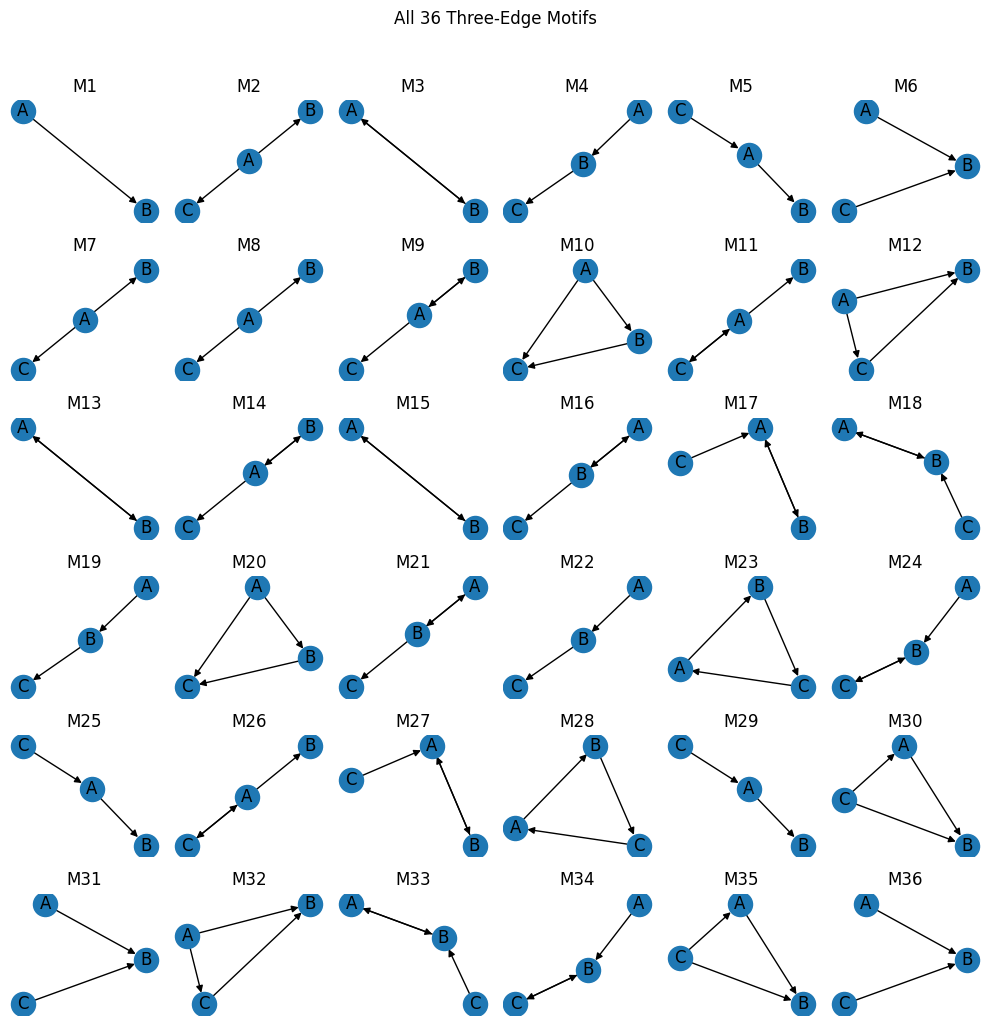

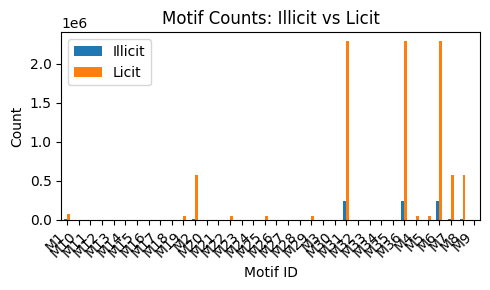

+--------+-------------+-----------+----------------------+
|motif_id|illicit_count|licit_count|illicit_to_licit_ratio|
+--------+-------------+-----------+----------------------+
|M6      |243888       |2284789    |0.10674421139107375   |
|M31     |243888       |2284789    |0.10674421139107375   |
|M36     |243888       |2284789    |0.10674421139107375   |
|M1      |5772         |80231      |0.07194226670488964   |
|M4      |1386         |48839      |0.028378959438153935  |
+--------+-------------+-----------+----------------------+
only showing top 5 rows

Global χ² = 141327.67, p‐value = 0, dof = 18

Top 5 motifs by Fisher p‐value:
motif_id  illicit   licit  odds_ratio  p_value
      M8     8445  567370    0.163385      0.0
      M6   243888 2284789    1.347370      0.0
      M5     1284   48941    0.302982      0.0
     M19     1284   48941    0.302982      0.0
      M2     8445  567370    0.163385      0.0


<Figure size 640x480 with 0 Axes>

In [14]:
%matplotlib inline
%run -i motif_detection.py

From the bar chart of Motif Counts we can see that most of the 36 motifs do not appear at all in our data for delta = 1. This suggests that we can potentially limit our search in future analysis on larger and unlabelled datasets to just this subset of motifs for speed and relevancy. We can see from the second plot that licit flows dominate in sheer volume, but a handful of motifs show relatively elevated illicit presence. Motifs M6, M31, and M36 all register the highest illicit counts, which perhaps merits further investigation. Normalising by total counts, M6 stands out as “fraud‐heavy” relative to other motifs, as we can see in the odds ratio of 1.35. These specific triadic structures (involving mixed bidirectional edges and small cycles) could therefore be particularly discriminative features for flagging illicit activity.
The hypothesis test conducted gives us further statistical insight into the overweighting of specific motifs in illicit transactions. 

### Interpretation of Motif‐Class Association Tests

The global χ²‐test (χ² = 141 327.7, p ≈ 0, d.f. = 18) provides overwhelming evidence that the distribution of 3-edge motifs is not independent of transaction class. There appears to be a strong association between the occurence and frequency of motif patterns and different frequencies between licit vs. illicit flows. We therefore have significant evidence to reject H_0. 

### Key Per-Motif Findings

For our Fisher test, the top 5 motifs by illicit counts give us significant insight into differences in patterns that occur between the two classes. 

| Motif | Illicit Count | Licit Count | Odds Ratio | Representation      |
|:-----:|:-------------:|:-----------:|:----------:|:----------------|
| **M6**  | 243 888       | 2 284 789    | **1.35**     | Over represendted in illicit |
| **M5**  |   1 284       |    48 941    | 0.30       | Under-represented in illicit          |
| **M19** |   1 284       |    48 941    | 0.30       | Under-represented in illicit          |
| **M2**  |   8 445       |   567 370    | 0.16       | Strongly under-represented in illicit |
| **M8**  |   8 445       |   567 370    | 0.16       | Strongly under-represented in illicit |


### Implications

- The significant global Chi-squared result confirms that motif structure alone carries predictive power for classifying transactions.  
- M6 stands out as the single motif most enriched in illicit activity—tracking its occurrence could improve early fraud alerts.  
- Motifs like M2 and M8, (the same pattern but with nodes in a different order) which are almost absent in illicit flows, could serve as negative indicators of fraud.  
- Together, these structural signatures offer a promising set of features for future machine-learning models aiming to distinguish illicit from legitimate transaction behavior.


### Conclusion and Further research 

In summary, this motif‐based analysis demonstrates that small, three‐edge transaction motifs carry statistically significant signals of illicit activity, and serves as a good starting point for future research. Searching through the 36 possible three-node motifs gave us insight into which motifs are common in crypto currency transaction networks, and which motifs are more likely to be indicative of illicit or licit activity. There are many avenues that could be taken to both deepen and broaden this work. First, we could extend beyond three‐edge motifs to more complex subgraphs such as four, five or higher‐step chains, multi‐node stars, or cliques to capture higher‐order laundering structures. Secondly we could integrate the bipartite address–transaction graph (rather than only the transaction‐level graph) to reveal how wallets cluster through shared transactions, enabling the potential discovery of cross‐address coordination motifs. Third, systematically varying the time‐window parameter delta and profiling motif prevalence as a function of delta could illuminate the temporal scales at which different illicit motifs emerge. Finally, these motif counts and richer temporal‐structural features could be fed into a Temporal Graph Attention Network (TGAT) or another GNN, constructing a dynamic graph where nodes are transactions, edges carry timestamps (and potentially monetary value), and motif‐based statistics are encoded as node or edge attributes. A supervised TGAT could then learn to attend over both local connectivity and motif contexts to flag illicit entities in real time. The learnings from this analysis could also be tested on other similar datasets to see if the most common motifs in illicit transactions here are also prevalent across other datasets. 

### Bibliography

Arnold, N. A., Zhong, P., Ba, C. T., Steer, B., Mondragon, R., Cuadrado, F., Lambiotte, R., & Clegg, R. G. (2024). Insights and caveats from mining local and global temporal motifs in cryptocurrency transaction networks. arXiv: 2402.09272

Weber, M., Domeniconi, G., Chen, J., Weidele, D. K. I., Bellei, C., Robinson, T., & Leiserson, C. E. (2019). Anti-money laundering in Bitcoin: Experimenting with graph convolutional networks for financial forensics. arXiv: 1908.02591